In [3]:
from glob import glob
from satpy import Scene
import xarray as xr
import numpy as np
import proplot as pplt

import sys
sys.path.append("../scripts")

from s5p_lnox_amf import cal_bamf, cal_amf

In [4]:
def cal_tropo(pressure, itropo):
    '''Calculate tropopause pressure based on index'''

    # get fill_values and overwrite with 0, because index array should be int.
    # Check submitted issue by Xin:
    #   https://github.com/pydata/xarray/issues/3955
    tropo_bool = itropo == itropo._FillValue
    itropo = xr.where(tropo_bool, 0, itropo)

    # isel with itropo
    ptropo = pressure.isel(layer=itropo.load())

    # mask data and set fill_value pixels to nan
    ptropo = xr.where(tropo_bool, np.nan, ptropo).rename('tropopause_pressure')

    return ptropo

In [14]:
def load_tropomi(filename):
    """Load TROPOMI NO2 L2 products by satpy"""
    scn = Scene(filename, reader='tropomi_l2')
    vnames = ['cloud_radiance_fraction_nitrogendioxide_window', 'cloud_fraction_crb_nitrogendioxide_window',
              'cloud_pressure_crb',
              'cloud_albedo_crb', 'surface_albedo_nitrogendioxide_window',
              'assembled_lat_bounds', 'assembled_lon_bounds',
              'longitude', 'latitude', 'qa_value',
              'tm5_constant_a', 'tm5_constant_b', 'surface_pressure', 'tm5_tropopause_layer_index',
              'averaging_kernel', 'air_mass_factor_troposphere', 'air_mass_factor_clear', 'air_mass_factor_cloudy',
              'oxygen_oxygen_dimer_slant_column_density',
              'nitrogendioxide_ghost_column', 'nitrogendioxide_tropospheric_column',
              'nitrogendioxide_slant_column_density', 'nitrogendioxide_stratospheric_column', 'air_mass_factor_stratosphere',
              'solar_zenith_angle', 'viewing_zenith_angle', 'solar_azimuth_angle', 'viewing_azimuth_angle',
              ]

    if 'no2_vmr' in scn.available_dataset_names():
        vnames += ['no2_vmr', 'temperature']
        scn.load(vnames)
        scn['no2_vmr'] = scn['no2_vmr'].assign_coords({'longitude': scn['nitrogendioxide_tropospheric_column'].longitude})
    else:
        scn.load(vnames)

    scn['amf_geo'] = 1/np.cos(np.radians(scn['solar_zenith_angle'])) + 1/np.cos(np.radians(scn['viewing_zenith_angle']))

    scn['SCD_Strato'] = scn['nitrogendioxide_stratospheric_column'] * scn['air_mass_factor_stratosphere']
    scn['SCD_Trop'] = scn['nitrogendioxide_slant_column_density'] - scn['SCD_Strato']

    scn['SCD_Strato'] = scn['SCD_Strato'].rename('SCD_Strato')
    scn['SCD_Trop'] = scn['SCD_Trop'].rename('SCD_Trop')
    scn['SCD_Strato'].attrs['units'] = 'mol m-2'
    scn['SCD_Trop'].attrs['units'] = 'mol m-2'

    # calculate pressure levels
    a = scn['tm5_constant_a']
    b = scn['tm5_constant_b']
    psfc = scn['surface_pressure']

    low_p = (a[:, 0] + b[:, 0]*psfc)/1e2
    high_p = (a[:, 1] + b[:, 1]*psfc)/1e2

    scn['p'] = xr.concat([low_p, high_p.isel(layer=-1)], dim='layer')
    scn['p'] = scn['p'].rolling({'layer': 2}).mean()[1:, ...].load()
    scn['p'] = scn['p'].rename('tm5_pressure')
    scn['p'].attrs['units'] = 'hPa'

    itropo = scn['tm5_tropopause_layer_index']
    scn['ptropo'] = cal_tropo(scn['p'], itropo)

    # assign lon/lat coords
    scn['p'] = scn['p'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['solar_zenith_angle'] = scn['solar_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_clear'] = scn['air_mass_factor_clear'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['air_mass_factor_cloudy'] = scn['air_mass_factor_cloudy'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['nitrogendioxide_slant_column_density'] = scn['nitrogendioxide_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['viewing_zenith_angle'] = scn['viewing_zenith_angle'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )
    scn['oxygen_oxygen_dimer_slant_column_density'] = scn['oxygen_oxygen_dimer_slant_column_density'].assign_coords(
        {'longitude': scn['nitrogendioxide_tropospheric_column'].longitude}
        )

    return scn

In [15]:
filename = glob('../data/tropomi/201908/S5P_PAL__L2__NO2____20190811T00*')
scn = load_tropomi(filename)

## Reproduce the official AMFs

In [11]:
lut_pattern = glob('../data/tropomi/S5P_OPER_LUT_NO2AMF*')
lut = xr.open_mfdataset(lut_pattern, combine='by_coords')

In [16]:
# calculate box amf
bAmfClr, bAmfCld, _ = cal_bamf(scn, lut)

In [17]:
ds_profile = xr.Dataset({'no2': scn['no2_vmr'].transpose('layer',
                                                         ...,
                                                         transpose_coords=False),
                         'tk': scn['temperature'].transpose('layer',
                                                            ...,
                                                            transpose_coords=False),
                        })

# calculate amf, scattering weights and averaging kernel
ds = cal_amf(scn, ds_profile, bAmfClr, bAmfCld,)

ValueError: arguments without labels along dimension 'layer' cannot be aligned because they have different dimension sizes: {33, 34}

In [ ]:
ds

In [10]:
def plot_cld(scn, lon_min, lon_max, lat_min, lat_max):
    """Plot the cloud variabls"""
    fig, axs = pplt.subplots(ncols=3)

    mask = (scn['longitude'] >= lon_min) & \
        (scn['longitude'] <= lon_max) & \
        (scn['latitude'] >= lat_min) & \
        (scn['latitude'] <=lat_max)

    scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[0],
                cmap='Balance', cmap_kw={'cut': -0.1}, vmin=-3e-5, vmax=3e-5,  discrete=False,
                )

    (scn['cloud_pressure_crb']/1e2).where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[1],
                cmap='Blues', vmin=100, vmax=1e3, discrete=False)

    scn['cloud_radiance_fraction_nitrogendioxide_window'].where(mask, drop=True).plot(
                x='longitude', y='latitude', ax=axs[2],
                cmap='Blues_r', vmin=0, vmax=1, discrete=False)

    axs.format(xlim=(lon_min, lon_max), ylim=(lat_min, lat_max),
               xlabel='Longitude', ylabel='Latitude', title='',
               toplabels=['VCD_Trop', 'Cloud Pressure', 'Cloud Radiance Fraction'],
               facecolor='Gray'
               )

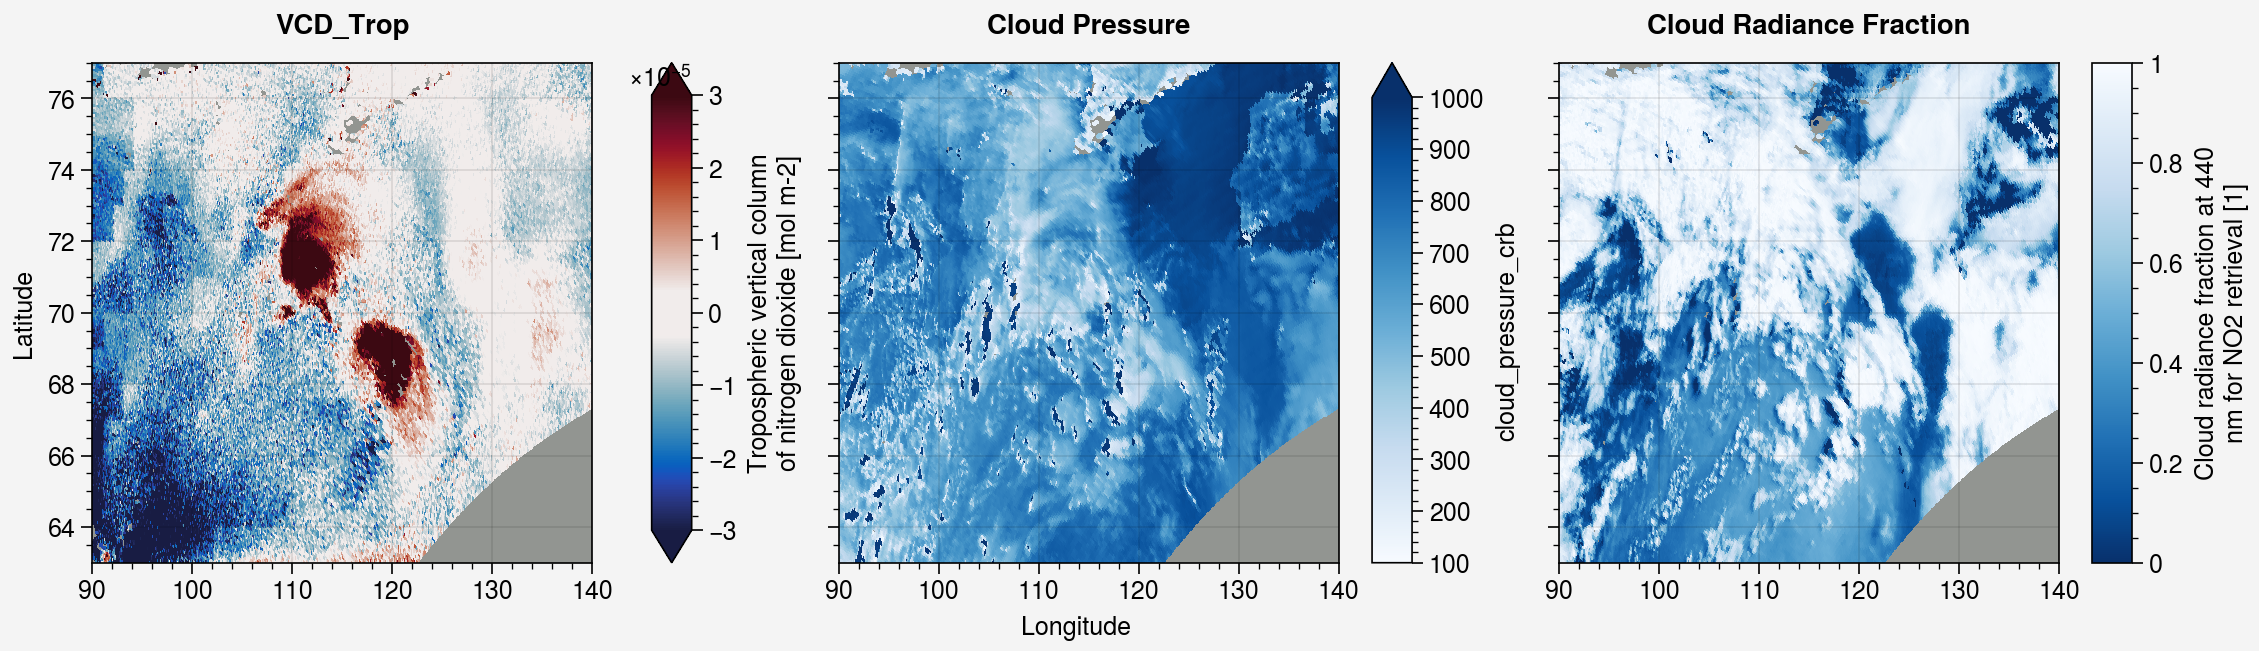

In [11]:
lon_min=90; lon_max=140; lat_min=63; lat_max=77

plot_cld(scn, lon_min, lon_max, lat_min, lat_max)

In [12]:
def mask_scn(scn, lon_min, lon_max, lat_min, lat_max):
    """mask the Scene to the lightning NO2 region"""
    mask = (scn['longitude'] >= lon_min) & \
           (scn['longitude'] <= lon_max) & \
           (scn['latitude'] >= lat_min) & \
           (scn['latitude'] <=lat_max)

    return scn['SCD_Strato'].where(mask, drop=True), \
           scn['SCD_Trop'].where(mask, drop=True), \
           scn['nitrogendioxide_tropospheric_column'].where(mask, drop=True), \
           scn['no2_vmr'].where(mask, drop=True) ,\
           scn['p'].where(mask, drop=True), \
           scn['ptropo'].where(mask, drop=True)

In [ ]:
def plot_no2_profile(scn_list, lon_min, lon_max, lat_min, lat_max):
    """Plot the mean TM5 NO2 profile over the selected convective region"""
    _, _, _, no2_pre, pressure_pre, ptropo_pre = mask_scn(scn_list[0], lon_min, lon_max, lat_min, lat_max)
    no2_pre = no2_pre.mean(['x', 'y'])
    ptropo_pre = ptropo_pre.mean(['x', 'y'])
    pressure_pre = pressure_pre.mean(['x', 'y'])

    fig, axs = pplt.subplots()

    l_noltng_before = axs.plot(no2_pre*1e12, pressure_pre, label='no lightning (one day before)', c='blue6')
    l_ltng = axs.plot(no2_ltng*1e12, pressure_ltng, label='lightning', c='orange6')
    l_noltng_after = axs.plot(no2_post*1e12, pressure_post, label='no lightning (one day after)', c='green6')

    # plot the ptropo line
    l_tropo_pre = axs.axhline(ptropo_pre, ls='--', color='blue6', label='Tropopause (one day before)')

    axs.legend([l_noltng_before, l_ltng, l_noltng_after, l_tropo_pre, l_tropo_ltng, l_tropo_post], loc='r', ncols=1)
    axs.format(xlabel='TM5 a priori NO2 (pptv)', ylabel='Pressure (hPa)', ylim=(1000, 100), xlim=(0, 300))